In [1]:
import sys
sys.path.append('/home/shiftpub/Dynamic_AMM/inf_step_exp')

from vector_train import AMM

import torch    
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

In [2]:



def generate_results_df(mu, sigma, gamma):
    # First create an AMM instance
    amm = AMM(
        L=1000,
        gamma=gamma,
        sigma=sigma,
        delta_t=1,
        mu=mu,
        fee_model='distribute',
        fee_source='outgoing',
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

    # Generate initial states
    states = amm.generate_training_data(num_samples=100)
    states_np = states.cpu().numpy()

    # Generate scenarios
    num_scenarios = 100
    mu = mu
    sigma = sigma
    delta_t = 1

    # Set random seed for reproducibility
    np.random.seed(42)
    random_normals = np.random.normal(0, 1, size=(len(states_np), num_scenarios))
    drift = (mu - 0.5 * sigma**2) * delta_t
    diffusion = sigma * np.sqrt(delta_t)

    # Calculate new prices
    initial_prices = states_np[:, 0].reshape(-1, 1)
    new_prices = initial_prices * np.exp(drift + diffusion * random_normals)

    # Calculate price ratios and bounds for AMM mechanics
    initial_x = states_np[:, 1].reshape(-1, 1)
    initial_y = states_np[:, 2].reshape(-1, 1)
    price_ratio = initial_y / initial_x
    p_upper = price_ratio / (1 - amm.gamma)
    p_lower = price_ratio * (1 - amm.gamma)

    # Initialize arrays for new x, y values
    new_x = np.zeros_like(new_prices)
    new_y = np.zeros_like(new_prices)

    # Create masks for the conditions
    above_mask = new_prices > p_upper
    below_mask = new_prices < p_lower
    within_mask = ~(above_mask | below_mask)

    # Calculate new x, y values based on conditions
    new_x[above_mask] = amm.L / np.sqrt((1 - amm.gamma) * new_prices[above_mask])
    new_y[above_mask] = amm.L * np.sqrt((1 - amm.gamma) * new_prices[above_mask])

    new_x[below_mask] = amm.L * np.sqrt((1 - amm.gamma) / new_prices[below_mask])
    new_y[below_mask] = amm.L * np.sqrt(new_prices[below_mask] / (1 - amm.gamma))

    new_x[within_mask] = np.repeat(initial_x, num_scenarios, axis=1)[within_mask]
    new_y[within_mask] = np.repeat(initial_y, num_scenarios, axis=1)[within_mask]

    # Vectorized fee calculations
    flat_prices = new_prices.flatten()
    flat_x = new_x.flatten()
    flat_y = new_y.flatten()

    # Calculate fees in one go
    flat_incoming_fees = amm.calculate_fee_ingoing(flat_prices, flat_x, flat_y)
    flat_outgoing_fees = amm.calculate_fee_outgoing(flat_prices, flat_x, flat_y)

    # Reshape back to original shape
    incoming_fees = flat_incoming_fees.reshape(new_prices.shape)
    outgoing_fees = flat_outgoing_fees.reshape(new_prices.shape)

    # Create DataFrame for initial states
    initial_states_df = pd.DataFrame({
        'state_idx': np.arange(len(states_np)),
        'p': states_np[:, 0],
        'x': states_np[:, 1],
        'y': states_np[:, 2],
        'immediate_reward': states_np[:, 0] * states_np[:, 1] + states_np[:, 2]
    })

    # Create scenarios DataFrame
    scenarios_data = []
    for i in range(len(states_np)):
        for j in range(num_scenarios):
            scenario = {
                'state_idx': i,
                'new_state_idx': i * num_scenarios + j,
                'initial_p': states_np[i, 0],
                'initial_x': states_np[i, 1],
                'initial_y': states_np[i, 2],
                'initial_immediate_reward': states_np[i, 0] * states_np[i, 1] + states_np[i, 2],
                'new_p': new_prices[i, j],
                'new_x': new_x[i, j],
                'new_y': new_y[i, j],
                'new_immediate_reward': new_prices[i, j] * new_x[i, j] + new_y[i, j],
                'incoming_fee': incoming_fees[i, j],
                'outgoing_fee': outgoing_fees[i, j]
            }
            scenarios_data.append(scenario)
            
    # Convert to DataFrame
    results_df = pd.DataFrame(scenarios_data)
    discount_factor = np.exp(-mu * delta_t)
    # Add analysis columns
    results_df['reward_diff_in'] = (
        discount_factor * (results_df['new_immediate_reward'] + results_df['incoming_fee']) - 
        results_df['initial_immediate_reward']
    )
    results_df['reward_diff_out'] = (
        discount_factor * (results_df['new_immediate_reward'] + results_df['outgoing_fee']) - 
        results_df['initial_immediate_reward']
    )
    results_df['pool_diff'] = (
        discount_factor * (results_df['new_immediate_reward']) - 
        results_df['initial_immediate_reward']
    )
    results_df['diff_out_in'] = results_df['reward_diff_out'] - results_df['reward_diff_in']
    results_df['is_exercise_profitable_in'] = results_df['reward_diff_in'] > 0
    results_df['is_exercise_profitable_out'] = results_df['reward_diff_out'] > 0

    
    
    return results_df
    
def plot_diff(mu, sigma, gamma):
    
    results_df = generate_results_df(mu, sigma, gamma)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Plot 1: Scatter plot of reward differences vs price for all scenarios
    axes[0].scatter(results_df['new_p']/results_df['initial_p'], results_df['reward_diff_in'], 
                    alpha=0.1, label='Incoming Fee', color='blue')
    axes[0].axhline(y=0, color='gray', linestyle=':', label='Break-even')
    axes[0].axvline(x=1, color='red', linestyle=':', label='Initial Price')
    axes[0].set_xlabel('New Price / Initial Price')
    axes[0].set_ylabel('Difference')
    axes[0].set_title('Account Profit Difference with Incoming Fee')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xticks(np.arange(1, 8, 1))

    # Plot 2: Scatter plot of reward differences vs price for all scenarios
    axes[1].scatter(results_df['new_p']/results_df['initial_p'], results_df['reward_diff_out'], 
                    alpha=0.1, label='Outgoing Fee', color='green')
    axes[1].axhline(y=0, color='gray', linestyle=':', label='Break-even')
    axes[1].axvline(x=1, color='red', linestyle=':', label='Initial Price')
    axes[1].set_xlabel('New Price / Initial Price')
    axes[1].set_ylabel('Difference')
    axes[1].set_title('Account Profit Difference with Outgoing Fee')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xticks(np.arange(1, 8, 1))
    

    
    plt.tight_layout()
    plt.show()
    
def plot_diff_narrow(mu, sigma, gamma, price_ratio_range=(0.9, 1.1)):

    results_df = generate_results_df(mu, sigma, gamma)

    # Filter for narrow price ratio range
    results_df['price_ratio'] = results_df['new_p'] / results_df['initial_p']
    narrow_df = results_df[
        (results_df['price_ratio'] >= price_ratio_range[0]) & 
        (results_df['price_ratio'] <= price_ratio_range[1])
    ]

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Pool value change
    axes[0,0].scatter(narrow_df['price_ratio'], narrow_df['pool_diff'], 
                    alpha=0.1, label='Pool Change', color='orange')
    axes[0,0].axhline(y=0, color='gray', linestyle=':', label='Break-even')
    axes[0,0].axvline(x=1, color='red', linestyle=':', label='Initial Price')
    axes[0,0].set_xlabel('New Price / Initial Price')
    axes[0,0].set_ylabel('Difference')
    axes[0,0].set_title('Pool Value Change')
    axes[0,0].legend(loc='lower right')
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Fee difference (Outgoing - Incoming)
    axes[0,1].scatter(narrow_df['price_ratio'], narrow_df['diff_out_in'], 
                    alpha=0.1, label='Out - In', color='purple')
    axes[0,1].axvline(x=1, color='red', linestyle=':', label='Initial Price')
    axes[0,1].set_xlabel('New Price / Initial Price')
    axes[0,1].set_ylabel('Difference')
    axes[0,1].set_title('Fee Difference (Out - In)')
    axes[0,1].legend(loc='lower right')
    axes[0,1].grid(True, alpha=0.3)

    # Plot 3: Detailed view of incoming fee difference
    axes[1,0].scatter(narrow_df['price_ratio'], narrow_df['reward_diff_in'], 
                    alpha=0.1, label='Incoming Fee', color='blue')
    axes[1,0].axhline(y=0, color='gray', linestyle=':', label='Break-even')
    axes[1,0].axvline(x=1, color='red', linestyle=':', label='Initial Price')
    axes[1,0].set_xlabel('New Price / Initial Price')
    axes[1,0].set_ylabel('Difference')
    axes[1,0].set_title('Account Profit Difference with Incoming Fee')
    axes[1,0].legend(loc='lower right')
    axes[1,0].grid(True, alpha=0.3)

    # Plot 4: Detailed view of outgoing fee difference
    axes[1,1].scatter(narrow_df['price_ratio'], narrow_df['reward_diff_out'], 
                    alpha=0.1, label='Outgoing Fee', color='green')
    axes[1,1].axhline(y=0, color='gray', linestyle=':', label='Break-even')
    axes[1,1].axvline(x=1, color='red', linestyle=':', label='Initial Price')
    axes[1,1].set_xlabel('New Price / Initial Price')
    axes[1,1].set_ylabel('Difference')
    axes[1,1].set_title('Account Profit Difference with Outgoing Fee')
    axes[1,1].legend(loc='lower right')
    axes[1,1].grid(True, alpha=0.3)

    

    plt.tight_layout()
    plt.show()



### Parameters
- Initial Liquidity (L): 1000
- Fee Rate (γ): 5%
- Volatility (σ): 0.5
- Time Step (Δt): 1
- Drift (μ): (0.0, 0.01)
- Discount Factor: $e^{-\mu \Delta_t}$

### Plot Descriptions

#### 1. Incoming Fee Analysis
- **X-axis**: Price Ratio (New Price / Initial Price)
- **Y-axis**: Accounting Profits Difference (Discount_Factor $\cdot$ (New Pool Value + Incoming Fee) - Initial Pool Value)

#### 2. Outgoing Fee Analysis
- **X-axis**: Price Ratio (New Price / Initial Price)
- **Y-axis**: Accounting Profits Difference (Discount_Factor $\cdot$ (New Pool Value + Outgoing Fee) - Initial Pool Value)

#### 3. Fee Difference (Outgoing - Incoming)
- **X-axis**: Price Ratio (New Price / Initial Price)
- **Y-axis**: Difference between Outgoing and Incoming Fee (Outgoing Fee - Incoming Fee)

#### 4. Pool Value Change
- **X-axis**: Price Ratio (New Price / Initial Price)
- **Y-axis**: Change in Pool Value (Without Fees) (Discount_Factor $\cdot$ New Pool Value - Initial Pool Value)

#### Intepretation
- Pool value is driven by external price (using y as numeraire). Increasing price leads to higher pool value, and vice versa.
- "Never Start" assumption is not valid because LPs should wait at least one more step if price goes up.

In [ ]:
mu = 0.00
sigma = 0.5
gamma = 0.1

# plot_diff(mu, sigma, gamma)
plot_diff_narrow(mu, sigma, gamma, price_ratio_range=(0.9, 1.1))
plot_diff(mu, sigma, gamma)

In [ ]:
mu = 0.03
sigma = 0.5
gamma = 0.1

# plot_diff(mu, sigma, gamma)
plot_diff_narrow(mu, sigma, gamma, price_ratio_range=(0.9, 1.1))
plot_diff(mu, sigma, gamma)

In [2]:
import sys
import pandas as pd
sys.path.append('/home/shiftpub/Dynamic_AMM/inf_step_exp')
from train import ParametricValueModel
import numpy as np
from tqdm import tqdm

sigmas = np.round(np.arange(0.1, 8.1, 0.1), 1)
mus = [0]
gammas = np.linspace(0.0001, 0.9, 1000)

results_df = pd.DataFrame()

for sigma in tqdm(sigmas, desc='sigma'):
    for mu in mus:
        for gamma in gammas:
            model = ParametricValueModel(mu, sigma, gamma)
            df = model.generate_raw_data(L=100, num_samples=1)
            results_df = pd.concat([results_df, df])
            
print(results_df.head().to_markdown())     



sigma: 100%|██████████| 80/80 [01:27<00:00,  1.09s/it]

|    |   state_idx |   p |   x |   y |     gamma |   mu |   sigma |   original_pool |   expected_incoming_fee |   expected_outgoing_fee |   expected_pool |   discounted_pool |   expected_incoming_value |   expected_outgoing_value |   discounted_incoming_value |   discounted_outgoing_value |
|---:|------------:|----:|----:|----:|----------:|-----:|--------:|----------------:|------------------------:|------------------------:|----------------:|------------------:|--------------------------:|--------------------------:|----------------------------:|----------------------------:|
|  0 |           0 |   1 | 100 | 100 | 0.0001    |    0 |     0.1 |             200 |             0.000385823 |             0.000411767 |          199.75 |            199.75 |                   199.751 |                   199.751 |                     199.751 |                     199.751 |
|  0 |           0 |   1 | 100 | 100 | 0.0010008 |    0 |     0.1 |             200 |             0.00381993  |             

In [5]:
results_df = pd.read_csv('results.csv')

In [ ]:
# Create a 4x4 grid of plots with different parameter combinations
import matplotlib.pyplot as plt
import numpy as np
from train import ParametricValueModel

# Parameter values to explore
sigma_values = [0.2, 0.5, 0.8]  # Volatility
mu_values = [0.0, 0.1, 0.2]    # Drift
gamma_value = 0.1             # We'll keep gamma fixed for simplicity

# Create a 4x4 grid of plots
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
fig.suptitle('Comparison of Original Pool vs Discounted Values for Various Parameters', fontsize=16)

# Iterate through parameter combinations
for i, sigma in enumerate(sigma_values):
    for j, mu in enumerate(mu_values):
        # Generate data for this parameter combination
        model = ParametricValueModel(mu, sigma, gamma_value)
        df = model.generate_raw_data(1000)
        
        # Get the current axis
        ax = axes[i, j]
        
        # Create the plot on this axis
        ax.plot(df['p'], df['original_pool'], 'o-', label='Original Pool', markersize=2, color='blue')
        ax.plot(df['p'], df['discounted_incoming_value'], 'x-', label='Discounted Incoming', markersize=2, color='green')
        ax.plot(df['p'], df['discounted_outgoing_value'], '+-', label='Discounted Outgoing', markersize=2, color='red')
        
        ax.set_xlabel('Price (p)', fontsize=10)
        ax.set_ylabel('Value', fontsize=10)
        ax.set_title(f'σ={sigma}, μ={mu}, γ={gamma_value}', fontsize=12)
        
        # Only show legend on the first plot
        if i == 0 and j == 0:
            ax.legend(fontsize=10)
        
        ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to make room for suptitle
plt.show()

In [ ]:
import seaborn as sns
# Create heatmap
# Create figure with 3 subplots for different gamma values
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Heatmaps of mu vs sigma vs out-in for different gamma values', fontsize=16)
selected_gammas = [0.01, 0.05, 0.1]
for i, gamma in enumerate(selected_gammas):
    gamma_df = results_df[results_df['gamma'] == gamma]
    pivot = gamma_df.pivot_table(index='sigma', columns='mu', values='out-in')
    sns.heatmap(pivot.sort_index(ascending=False),  # Sort index in descending order
                ax=axes[i], 
                cmap='coolwarm',
                annot=False,
                fmt=".2f",
                cbar_kws={'label': 'out-in'})
    
    # Set labels and title
    axes[i].set_xlabel('mu')
    axes[i].set_ylabel('sigma')
    axes[i].set_title(f'gamma = {gamma}')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create heatmap
# Create figure with 3 subplots for different gamma values
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Heatmaps of mu vs sigma vs out-in for different gamma values', fontsize=16)
selected_gammas = [0.01, 0.05, 0.1]
for i, gamma in enumerate(selected_gammas):
    gamma_df = results_df[results_df['gamma'] == gamma]
    pivot = gamma_df.pivot_table(index='sigma', columns='mu', values='num_positive_out')
    sns.heatmap(pivot.sort_index(ascending=False),  # Sort index in descending order
                ax=axes[i], 
                cmap='coolwarm',
                annot=False,
                fmt=".2f",
                cbar_kws={'label': 'out-in'})
    
    # Set labels and title
    axes[i].set_xlabel('mu')
    axes[i].set_ylabel('sigma')
    axes[i].set_title(f'gamma = {gamma}')

In [ ]:
import seaborn as sns
# Create heatmap
# Create figure with 3 subplots for different gamma values
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Heatmaps of mu vs sigma vs out-in for different gamma values', fontsize=16)
selected_gammas = [0.01, 0.05, 0.1]
for i, gamma in enumerate(selected_gammas):
    gamma_df = results_df[results_df['gamma'] == gamma]
    pivot = gamma_df.pivot_table(index='sigma', columns='mu', values='num_positive_in')
    sns.heatmap(pivot.sort_index(ascending=False),  # Sort index in descending order
                ax=axes[i], 
                cmap='coolwarm',
                annot=False,
                fmt=".2f",
                cbar_kws={'label': 'out-in'})
    
    # Set labels and title
    axes[i].set_xlabel('mu')
    axes[i].set_ylabel('sigma')
    axes[i].set_title(f'gamma = {gamma}')

In [10]:
print(results_df.head().to_markdown())

|    |   state_idx |   p |   x |   y |     gamma |   original_pool |   expected_incoming_fee |   expected_outgoing_fee |   expected_pool |   discounted_pool |   expected_incoming_value |   expected_outgoing_value |   discounted_incoming_value |   discounted_outgoing_value |   out-ori |    in-ori |     out-in |
|---:|------------:|----:|----:|----:|----------:|----------------:|------------------------:|------------------------:|----------------:|------------------:|--------------------------:|--------------------------:|----------------------------:|----------------------------:|----------:|----------:|-----------:|
|  0 |           0 |   1 | 100 | 100 | 0.0001    |             200 |             0.000385823 |             0.000411767 |          199.75 |            199.75 |                   199.751 |                   199.751 |                     199.751 |                     199.751 | -0.249432 | -0.249458 | 2.594e-05  |
|  0 |           0 |   1 | 100 | 100 | 0.0010008 |             2

|    |   state_idx |   p |   x |   y |     gamma |   mu |   sigma |   original_pool |   expected_incoming_fee |   expected_outgoing_fee |   expected_pool |   discounted_pool |   expected_incoming_value |   expected_outgoing_value |   discounted_incoming_value |   discounted_outgoing_value |
|---:|------------:|----:|----:|----:|----------:|-----:|--------:|----------------:|------------------------:|------------------------:|----------------:|------------------:|--------------------------:|--------------------------:|----------------------------:|----------------------------:|
|  0 |           0 |   1 | 100 | 100 | 0.0001    |    0 |     0.1 |             200 |             0.000385823 |             0.000411767 |          199.75 |            199.75 |                   199.751 |                   199.751 |                     199.751 |                     199.751 |
|  0 |           0 |   1 | 100 | 100 | 0.0010008 |    0 |     0.1 |             200 |             0.00381993  |             

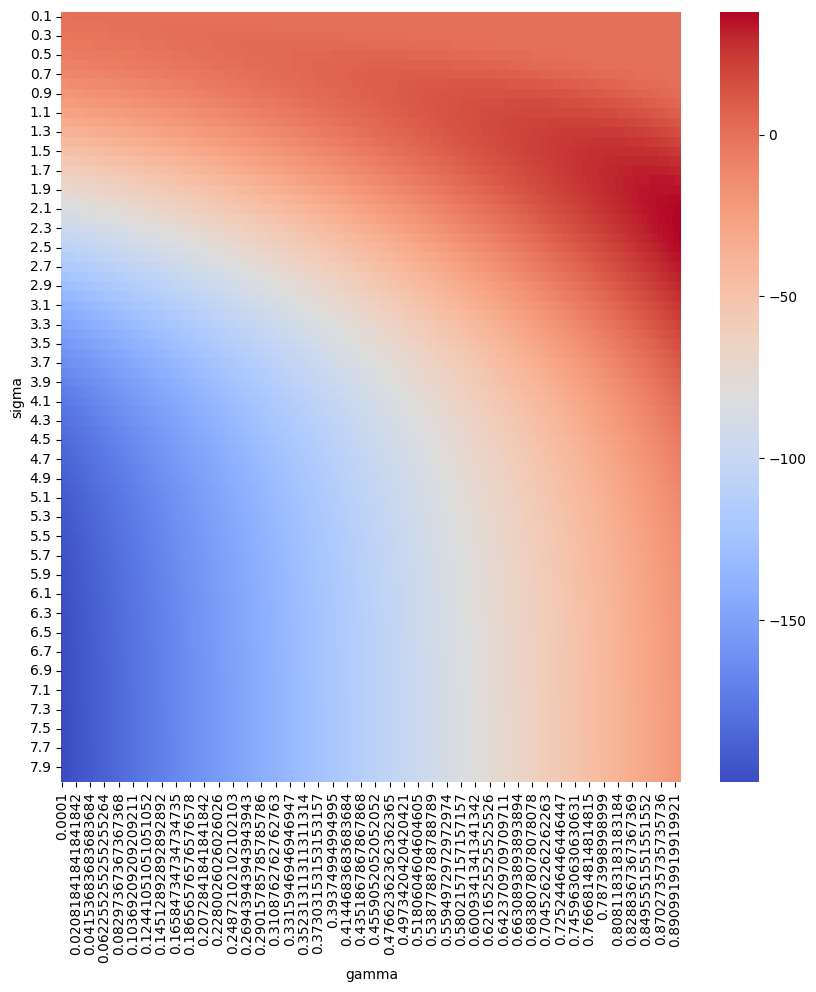

In [3]:
import pandas as pd

print(results_df.head().to_markdown())

results_df['out-ori'] = results_df['discounted_outgoing_value'] - results_df['original_pool']
results_df['in-ori'] = results_df['discounted_incoming_value'] - results_df['original_pool']
results_df['out-in'] = results_df['discounted_outgoing_value'] - results_df['discounted_incoming_value']

import seaborn as sns
import matplotlib.pyplot as plt
# Create heatmap for out-ori
plt.figure(figsize=(10, 10))
sns.heatmap(results_df.pivot_table(index='sigma', columns='gamma', values='out-ori'), cmap='coolwarm')
plt.show()


In [4]:
# show rows where discounted_outgoing_value is greater than original_pool
results_df[results_df['discounted_outgoing_value'] > results_df['original_pool']]


,state_idx,p,x,y,gamma,mu,sigma,original_pool,expected_incoming_fee,expected_outgoing_fee,expected_pool,discounted_pool,expected_incoming_value,expected_outgoing_value,discounted_incoming_value,discounted_outgoing_value,out-ori,in-ori,out-in
0,0,1.0,100.0,100.0,0.041537,0,0.1,200.0,0.091655,0.214943,199.785134,199.785134,199.876789,200.000078,199.876789,200.000078,0.000078,-0.123211,0.123289
0,0,1.0,100.0,100.0,0.042438,0,0.1,200.0,0.092370,0.219663,199.786480,199.786480,199.878850,200.006143,199.878850,200.006143,0.006143,-0.121150,0.127294
0,0,1.0,100.0,100.0,0.043338,0,0.1,200.0,0.093042,0.224349,199.787842,199.787842,199.880884,200.012191,199.880884,200.012191,0.012191,-0.119116,0.131307
0,0,1.0,100.0,100.0,0.044239,0,0.1,200.0,0.093672,0.228999,199.789220,199.789220,199.882893,200.018219,199.882893,200.018219,0.018219,-0.117107,0.135326
0,0,1.0,100.0,100.0,0.045140,0,0.1,200.0,0.094261,0.233610,199.790615,199.790615,199.884875,200.024224,199.884875,200.024224,0.024224,-0.115125,0.139349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,1.0,100.0,100.0,0.896397,0,4.2,200.0,10.917478,166.763184,33.319356,33.319356,44.236833,200.082540,44.236833,200.082540,0.082540,-155.763167,155.845707
0,0,1.0,100.0,100.0,0.897298,0,4.2,200.0,10.944791,166.899339,33.398480,33.398480,44.343271,200.297820,44.343271,200.297820,0.297820,-155.656729,155.954548
0,0,1.0,100.0,100.0,0.898198,0,4.2,200.0,10.972271,167.034928,33.478537,33.478537,44.450808,200.513465,44.450808,200.513465,0.513465,-155.549192,156.062657
0,0,1.0,100.0,100.0,0.899099,0,4.2,200.0,10.999920,167.169937,33.559545,33.559545,44.559465,200.729482,44.559465,200.729482,0.729482,-155.440535,156.170017


In [6]:
x = 100
y = 100
gamma = 0.1
sigma = 0.1
from scipy.integrate import quad
from scipy.stats import lognorm

def _lognormal_pdf(v: float, sigma: float) -> float:
    """Calculate lognormal PDF with or without drift"""
    return lognorm.pdf(v, s=sigma, scale=np.exp(-0.5 * sigma**2))

def _outgoing_price_effect(v: float, f: float) -> float:
    return 1 - np.sqrt(v/(1-f))

def value_integrand(v: float) -> float:
    return (2 * gamma * y * 
           _lognormal_pdf(v, sigma) * 
           _outgoing_price_effect(v, gamma))
value, _ = quad(lambda v: value_integrand(v), 1e-4, 1-gamma)

print(value)

0.04061132375106961


In [7]:
from CPMM import AMM

x = 100
y = 100
gamma = 0.1
sigma = 0.1

amm = AMM(L=100, gamma=gamma, sigma=0.5, mu=0.0, fee_model='distribute', fee_source='outgoing', device='cuda')

incoming_fee, outgoing_fee, pool = amm.calculate_fee(1, 100, 100)

print(incoming_fee, outgoing_fee, pool)

1.3448600129757375 2.652958605128032 194.08566701277
